In [1]:
import torch.nn as nn
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
torch.autograd.set_detect_anomaly(True)
import websocket, json, pprint, talib, numpy
import websockets
from binance.client import Client
from binance.enums import *
import joblib
import robin_stocks as rs
import config
import asyncio
import nest_asyncio
import time

In [2]:
rs.robinhood.login(username= config.RH_USER, password= config.RH_PASS, expiresIn=86400, by_sms=True)

{'access_token': 'eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiJ9.eyJleHAiOjE2NTI4MjQ0MTIsInRva2VuIjoiSVZVMXluUXBHa28xa3dRT3J3ZlVmenFQcHp0NloyIiwidXNlcl9pZCI6Ijk1MmFhMzljLTBhMjQtNDliMS05MjQ0LWE2NmM0ZTYzZDQzOCIsImRldmljZV9oYXNoIjoiNzZkMTM3YmU4YzExYTY1OTA4YjViNDIyOTkyMmYzZGIiLCJzY29wZSI6ImludGVybmFsIiwiZGN0IjoxNjUyMTIxMTM2LCJzZXJ2aWNlX3JlY29yZHMiOlt7ImhhbHRlZCI6ZmFsc2UsInNlcnZpY2UiOiJudW1tdXNfdXMiLCJzaGFyZF9pZCI6MSwic3RhdGUiOiJhdmFpbGFibGUifSx7ImhhbHRlZCI6ZmFsc2UsInNlcnZpY2UiOiJicm9rZWJhY2tfdXMiLCJzaGFyZF9pZCI6Niwic3RhdGUiOiJhdmFpbGFibGUifV0sInVzZXJfb3JpZ2luIjoiVVMiLCJvcHRpb25zIjp0cnVlLCJsZXZlbDJfYWNjZXNzIjpmYWxzZX0.KuT4wFtndQo_p50zmGwAxFQ4er6pK1jmrf1IAzG_oMW_dxF9WyWr2JINOVafB5GzDL0C1R-YDnhV3jiHcdcByG5agKIrk-rsIryczLUSvnWQUxHKVI6Cs5m9ZFGNCvFnyHkbKGIbGvh63Q_TqT-Hvb2i23dSjJ-B8fDzjzDhpInJmxTriAVVCxroJ1xygbVNDg9vODBSctX9NwaF2UpAhdEyAbG4_KrMgRkzVhM3DG1ZicZVgSrRJqpVPmdVwYdhSw2JBOOresWAZZXfXgTYV6eCz91m2kffWgIimgKmxh_t6XWc_jOPEQMORKWGzaL_6dAGa2kU-o_RoULPJlFfKw',
 'token_type': 'Bearer',
 'expires_in': 8640

In [3]:
#rs.robinhood.order_buy_crypto_by_price('ETH', 1)

In [4]:
data_set = 'data_1m.csv'
data = pd.read_csv(data_set)

#close = data.loc[:, "labels"]
close = data.loc[:, "closes"]
close = close.iloc[1:]
data = data.iloc[:-1]
data = data.drop(["labels"], axis=1)
data.head()


,opens,highs,lows,closes,volumes,qavs,numTrades,tbbavs,tbqavs,rsis,obvs
0,1.953039,1.951080,1.955038,1.953147,-0.284375,-0.283899,-0.369908,-0.215535,-0.214768,-0.937685,-0.064069
1,1.953039,1.951080,1.955038,1.953147,-0.284375,-0.283899,-0.369908,-0.215535,-0.214768,-0.937685,-0.064069
2,1.942114,1.951500,1.942859,1.953497,0.095107,0.132699,0.226473,0.090336,0.120266,-0.937685,-0.064069
3,1.942184,1.940218,1.936210,1.934308,-0.165093,-0.152983,-0.114316,-0.215535,-0.214768,2.204308,0.041702
4,1.934200,1.932230,1.936210,1.934308,-0.284375,-0.283899,-0.369908,-0.215535,-0.214768,2.246943,0.074948


In [5]:
data = data.to_numpy()
close = close.to_numpy()
#extra = np.shape(data)[0] % 32
#data = data[extra:, :]
data = torch.tensor(data)
data = data.to(torch.float)
#close = close[extra:]
close = torch.tensor(close)
close = close.to(torch.float)
data, X_test, close, y_test = train_test_split(data, close, test_size=0.5, shuffle = False)
print(np.shape(data))
class Dataset():
    def __init__(self, array, labels):
        self.array = array
        self.labels = labels

    def __len__(self):
        return self.array.shape[0]

    def __getitem__(self, idx):
        return self.array[idx, :], self.labels[idx]

torch.Size([20211, 11])


In [6]:
batch_size = 1 
fulldata = Dataset(data, close)
dataloader = DataLoader(fulldata, batch_size)
loss_function = nn.MSELoss()

testdata = Dataset(X_test, y_test)
testdataloader = DataLoader(testdata, batch_size)

pred_array = np.zeros(len(data))

In [7]:
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, HL_size, num_layers = 1):
        super(RNNModel, self).__init__()
        self.rnn = torch.nn.RNN(input_size=input_size,
                                hidden_size=HL_size,
                                num_layers=num_layers)
        
        self.linear = torch.nn.Linear(HL_size , 12)
        self.linear2 = torch.nn.Linear(12, 1)
        self.num_layers = num_layers
        self.hidden_size = HL_size
        
    def forward(self, inputs, hidden):
        out, hidden = self.rnn(inputs, hidden)
        pred = self.linear(out)
        pred = self.linear2(pred)

        #hidden = hidden.view(-1, 1, self.hidden_size)
        return pred, hidden
    
    def init_hidden(self, batch = 1):
        hidden = torch.randn(self.num_layers, batch, self.hidden_size)
        return hidden

def rnn_train():
    model = RNNModel(np.shape(data)[1], HL_size = 24, num_layers = 1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    hidden = model.init_hidden(batch_size)
    total_loss = 0
    for batch_idx, (batch, truth) in enumerate(dataloader):
        
        hidden = hidden.detach()

        batch = np.reshape(batch, (1, -1, 11))
        pred, hidden = model.forward(batch, hidden)

        pred = torch.squeeze(pred, 0)
        pred = torch.squeeze(pred, 1)
        #print(pred)
        pred_array[batch_idx] = pred.item()
        single_loss = loss_function(pred, truth)
        single_loss.backward(retain_graph=True)
        clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        optimizer.zero_grad()
        total_loss = total_loss + single_loss.item()
        if batch_idx % 100 == 0:
            print(batch_idx)
            print(total_loss)
            #print(hidden)
            total_loss = 0
            
    '''
    for name, param in model.named_parameters():
                if param.requires_grad:
                    print(name, param.data)
    '''
    return model, hidden
            
trained_model, final_hidden = rnn_train()

0
4.043981552124023
100
19.068843041308355
200
0.7615606429881154
300
0.09201472586670434
400
0.22991339291047552
500
0.1570450542474191
600
0.1493327742451811
700
0.058137934072703956
800
0.1353688449803485
900
0.030265891671774625
1000
0.1493763953452003
1100
0.06897761247893186
1200
0.08746340816463771
1300
0.26297663797737414
1400
0.1314326980746614
1500
0.17678675766984497
1600
0.3561485851960242
1700
0.07610101754619336
1800
0.09486649009568282
1900
0.7871557720825422
2000
0.6367516280497512
2100
0.2373008535016794
2200
0.113535454365433
2300
0.04898747804601555
2400
0.07352729657300472
2500
0.4275664650172075
2600
0.34841923929565155
2700
0.3289884750557803
2800
0.2019377230821675
2900
0.24188607676828155
3000
0.41649242764674455
3100
0.3188797512545989
3200
0.5870943819387549
3300
0.665961807308804
3400
0.2796480147816922
3500
0.2754325630077332
3600
0.074834250395174
3700
0.13426998413931557
3800
0.16572875012164445
3900
0.27340670857847726
4000
0.22389130390018863
4100
0.4893

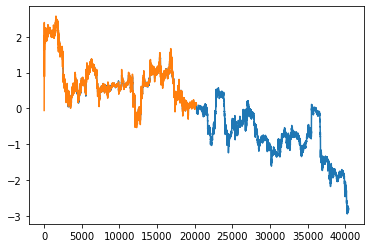

In [8]:
data2 = pd.read_csv(data_set)
truth_array = data2.loc[:, "closes"]
plt.plot(truth_array)
plt.plot(pred_array)
plt.show()

In [9]:
hidden = final_hidden
total_batches = 0
total_error = 0

#model = RNNModel(np.shape(data)[1], HL_size = 24, num_layers = 2)

optimizer = torch.optim.Adam(trained_model.parameters(), lr=0.02)
    
for batch_idx, (batch, truth) in enumerate(testdataloader):
    optimizer.zero_grad()
    hidden = hidden.detach()
    batch = np.reshape(batch, (1, -1, 11))
    pred, hidden = trained_model.forward(batch, hidden)
    pred = torch.squeeze(pred, 0)
    pred = torch.squeeze(pred, 1)
    single_loss = loss_function(pred, truth)
    single_loss.backward(retain_graph=True)
    clip_grad_norm_(trained_model.parameters(), 5)
    optimizer.step()
    total_batches += 1
    if (single_loss.item() < truth_array[batch_idx] and truth > truth_array[batch_idx]) or \
        (single_loss.item() > truth_array[batch_idx] and truth < truth_array[batch_idx]):
            total_error +=1
                                                                         
print(total_error)
print(total_batches)

1402
20212


## Live Prediction

In [10]:
SOCKET = "wss://stream.binance.com:9443/ws/ethusdt@kline_1m"

RSI_PERIOD = 14
TRADE_SYMBOL = 'ETHUSD'

in_position = False

client = Client(config.KEY, config.SECRET, tld='us')

scaler = joblib.load('standard_scaler_1m.save')

In [11]:
import time
currMilli = round(time.time() * 1000)
currCandles = client.get_klines(symbol='ETHUSDT', 
                                interval=Client.KLINE_INTERVAL_1MINUTE, 
                                startTime = (currMilli - 900000), 
                                endTime = (currMilli),
                                limit = 14)

#print(currCandles)


opens = [float(c[1]) for c in currCandles]
closes = [float(c[4]) for c in currCandles]
volumes = [float(c[5]) for c in currCandles]
highs = [float(c[2]) for c in currCandles]
lows = [float(c[3]) for c in currCandles]
qavs = [float(c[7]) for c in currCandles]
numTrades = [float(c[8]) for c in currCandles]
tbbavs = [float(c[9]) for c in currCandles]
tbqavs = [float(c[10]) for c in currCandles]

closes.reverse()
volumes.reverse()

rsis = []
obvs = []
scaled_df = None
hidden_squeeze = torch.squeeze(hidden, 1)
df_history = pd.DataFrame(data={"time": [], "opens": [], "highs": [], "lows": [], "closes": [], "volumes": [], "qavs": [], "numTrades": [], "tbbavs": [], "tbqavs": [], "rsis": [],"obvs": []})
count = 0
correct = 0
boughtPrev = False
closePrev = float(0)
predPrev = float(0)
money = float(0)


async def on_message():
    global hidden_squeeze, closePrev, boughtPrev, closes, in_position, opens, highs, lows, volumes, qavs, numTrades, tbbavs, tbqavs, rsis, obvs, df_history, money, count, correct
    
    
    #print('CLOSES: ', len(closes), closes)
    #print('received message')
    json_message = json.loads(message)
    #pprint.pprint(json_message)

    candle = json_message['k']
 
    is_candle_closed = candle['x']
    close = float(candle['c'])
    open_ = float(candle['o'])
    high = float(candle['h'])
    low = float(candle['l'])
    vol = float(candle['v'])
    qav = float(candle['q'])
    numTrade = float(candle['n'])
    tbbav = float(candle['V'])
    tbqav = float(candle['Q'])
    time = candle['t']

    if is_candle_closed:
        print("candle closed at {}".format(close))
        closes.insert(0, close)
        volumes.insert(0, vol)
        opens.append(float(open_))
        highs.append(float(high))
        lows.append(float(low))
        qavs.append(float(qav))
        numTrades.append(float(numTrade))
        tbbavs.append(float(tbbav))
        tbqavs.append(float(tbqav))
        
#         if(predPrev != float(0)):
#             df = pd.DataFrame(data={"opens": [opens[-1]], "highs": [highs[-1]], "lows": [lows[-1]], "closes": [closes[0]], "volumes": [volumes[0]], "qavs": [qavs[-1]], "numTrades": [numTrades[-1]], "tbbavs": [tbbavs[-1]], "tbqavs": [tbqavs[-1]], "rsis": [1],"obvs": [1]})
#             scaled_df = scaler.transform(df)
#             scaled_df = pd.DataFrame(scaled_df, columns = df.columns)
#             data = scaled_df.to_numpy()
#             truePred = data[0][3]
#             print("\nBack Propogate... \n")
                                  
#             predPrev =  torch.squeeze(predPrev, 1)
#             predPrev =  torch.squeeze(predPrev, 0)
#             truePred = torch.tensor(truePred)
#             truePred = truePred.to(torch.float)
            
#             print(predPrev, np.shape(predPrev), truePred, np.shape(truePred))

#             single_loss = loss_function(predPrev, truePred)
#             print('1')
#             single_loss.backward()
#             print('2')
#             clip_grad_norm_(trained_model.parameters(), 5)
#             print('3')
#             optimizer.step()
#             print('4')
#             optimizer.zero_grad()
        
        if(boughtPrev):
            print('here\n\n')
            change = close - closePrev
            money += change
            print('NEW PRICE: ', close, 'BOUGHT PRICE: ', closePrev, 'CHANGE: ', change, 'MONEY: ', money)
            boughtPrev = False
        
        if len(closes) > RSI_PERIOD: 
            count += 1
            np_closes = numpy.array(closes[:15])
            np_vols = numpy.array(volumes[:15])
            rsi = talib.RSI(np_closes, RSI_PERIOD)
            obv = talib.OBV(np_closes, np_vols)
            last_rsi = rsi[-1]
            last_obv = obv[-1]
            
            #print("the current rsi is {}".format(last_rsi))
            df = pd.DataFrame(data={"opens": [opens[-1]], "highs": [highs[-1]], "lows": [lows[-1]], "closes": [closes[0]], "volumes": [volumes[0]], "qavs": [qavs[-1]], "numTrades": [numTrades[-1]], "tbbavs": [tbbavs[-1]], "tbqavs": [tbqavs[-1]], "rsis": [last_rsi],"obvs": [last_obv]})
            scaled_df = scaler.transform(df)
            scaled_df = pd.DataFrame(scaled_df, columns = df.columns)
            
#             scaled_df_labeled = scaled_df
#             scaled_df_labeled['labels'] = [label]
#             print("SCALED DF", scaled_df_labeled.head())
            data = scaled_df.to_numpy()

            curr_close = float(data[0][3])
            print(data)
            
            data = torch.tensor(data)
            data = data.to(torch.float)
            pred, hidden_squeeze = trained_model(data, hidden_squeeze)
            print('PREDICTION', pred)
            prediction = float(pred.item())
            #predPrev = torch.clone(pred)
            
            hidden_squeeze = hidden_squeeze.detach()
            pred =  torch.squeeze(pred, 1)
            pred =  torch.squeeze(pred, 0)
            truePred = torch.tensor(curr_close)
            truePred = truePred.to(torch.float)
            
            print(pred, np.shape(pred), truePred, np.shape(truePred))

            single_loss = loss_function(pred, truePred)
            print('1')
            single_loss.backward(retain_graph=True)
            print('2')
            clip_grad_norm_(trained_model.parameters(), 5)
            print('3')
            optimizer.step()
            print('4')
            optimizer.zero_grad()
            
            if(prediction > curr_close):
                print("BUY AT: ", closes[0], 'TIME: ', time)
                closePrev = closes[0]
                boughtPrev = True
                scaled_df['time'] = [time]
                df_history = df_history.append(scaled_df, ignore_index = True)
                print('AFTER\n\n')
            

In [12]:
nest_asyncio.apply()
currMilli = round(time.time() * 1000)
df_history = pd.DataFrame(data={"time": [], "opens": [], "highs": [], "lows": [], "closes": [], "volumes": [], "qavs": [], "numTrades": [], "tbbavs": [], "tbqavs": [], "rsis": [],"obvs": []})


async def call_api():
    global currMilli, df_history
    
    currCandles = client.get_klines(symbol='ETHUSDT', 
                                    interval=Client.KLINE_INTERVAL_1MINUTE, 
                                    startTime = (currMilli - 900000), 
                                    endTime = (currMilli),
                                    limit = 14)
    opens = [float(c[1]) for c in currCandles]
    closes = [float(c[4]) for c in currCandles]
    volumes = [float(c[5]) for c in currCandles]
    highs = [float(c[2]) for c in currCandles]
    lows = [float(c[3]) for c in currCandles]
    qavs = [float(c[7]) for c in currCandles]
    numTrades = [float(c[8]) for c in currCandles]
    tbbavs = [float(c[9]) for c in currCandles]
    tbqavs = [float(c[10]) for c in currCandles]

    closes.reverse()
    volumes.reverse()

    rsis = []
    obvs = []
    scaled_df = None
    hidden_squeeze = torch.squeeze(hidden, 1)
    count = 0
    correct = 0
    boughtPrev = False
    closePrev = float(0)
    money = float(0)
    
    async with websockets.connect(SOCKET) as websocket:
        
        while(1):
            response = await websocket.recv()

            json_message = json.loads(response)

            #print(json_message)
            candle = json_message['k']

            is_candle_closed = candle['x']
            close = float(candle['c'])
            open_ = float(candle['o'])
            high = float(candle['h'])
            low = float(candle['l'])
            vol = float(candle['v'])
            qav = float(candle['q'])
            numTrade = float(candle['n'])
            tbbav = float(candle['V'])
            tbqav = float(candle['Q'])
            time = candle['t']

            if is_candle_closed:
                print("\n######################\ncandle closed at {}".format(close))
                closes.insert(0, close)
                volumes.insert(0, vol)
                opens.append(float(open_))
                highs.append(float(high))
                lows.append(float(low))
                qavs.append(float(qav))
                numTrades.append(float(numTrade))
                tbbavs.append(float(tbbav))
                tbqavs.append(float(tbqav))

                if(count > 0):
                    df = pd.DataFrame(data={"opens": [opens[-1]], "highs": [highs[-1]], "lows": [lows[-1]], "closes": [closes[0]], "volumes": [volumes[0]], "qavs": [qavs[-1]], "numTrades": [numTrades[-1]], "tbbavs": [tbbavs[-1]], "tbqavs": [tbqavs[-1]], "rsis": [1],"obvs": [1]})
                    scaled_df = scaler.transform(df)
                    scaled_df = pd.DataFrame(scaled_df, columns = df.columns)
                    data = scaled_df.to_numpy()
                    truePred = data[0][3]
                    
                    print("\nBack Propogate... \n")

                    hidden_squeeze = hidden_squeeze.detach()
                    pred =  torch.squeeze(pred, 1)
                    pred =  torch.squeeze(pred, 0)
                    truePred = torch.tensor(truePred)
                    truePred = truePred.to(torch.float)

                    single_loss = loss_function(pred, truePred)
                    single_loss.backward()
                    clip_grad_norm_(trained_model.parameters(), 5)
                    optimizer.step()
                    optimizer.zero_grad()
                    
                    prediction = float(pred.item())
                    print("CORRECT?: ", float(truePred.item()), prediction, closePrev)

                    if(truePred > closePrev and prediction > closePrev or truePred < closePrev and prediction < closePrev):
                        correct += 1
                    print("COUNT: ", count, "CORRECT: ", correct)

                if(boughtPrev):
                    change = close - closes[1]
                    money += change
                    print('NEW PRICE: ', close, 'BOUGHT PRICE: ', closePrev, 'CHANGE: ', change, 'MONEY: ', money)
                    boughtPrev = False

                if len(closes) > RSI_PERIOD: 
                    count += 1
                    np_closes = numpy.array(closes[:15])
                    np_vols = numpy.array(volumes[:15])
                    rsi = talib.RSI(np_closes, RSI_PERIOD)
                    obv = talib.OBV(np_closes, np_vols)
                    last_rsi = rsi[-1]
                    last_obv = obv[-1]

                    df = pd.DataFrame(data={"opens": [opens[-1]], "highs": [highs[-1]], "lows": [lows[-1]], "closes": [closes[0]], "volumes": [volumes[0]], "qavs": [qavs[-1]], "numTrades": [numTrades[-1]], "tbbavs": [tbbavs[-1]], "tbqavs": [tbqavs[-1]], "rsis": [last_rsi],"obvs": [last_obv]})
                    scaled_df = scaler.transform(df)
                    scaled_df = pd.DataFrame(scaled_df, columns = df.columns)

                    data = scaled_df.to_numpy()

                    curr_close = float(data[0][3])
                    print(data)

                    data = torch.tensor(data)
                    data = data.to(torch.float)
                    pred, hidden_squeeze = trained_model(data, hidden_squeeze)
                    print('PREDICTION', pred)
                    prediction = float(pred.item())
                    
                    if(prediction > curr_close):
                        print("BUY AT: ", closes[0], 'TIME: ', time)
                        closePrev = curr_close
                        boughtPrev = True
                        scaled_df['time'] = [time]
                        df_history = df_history.append(scaled_df, ignore_index = True)
                    else:
                        print("DONT BUY")
                    

asyncio.get_event_loop().run_until_complete(call_api())



######################
candle closed at 2425.87
[[-3.57553965e+00 -3.57925570e+00 -3.65594288e+00 -3.65232396e+00
   2.60376544e+02  2.15213929e+02  1.23932946e+02  1.89270767e+02
   1.56141536e+02 -1.15944924e-01  7.25261603e+01]]
PREDICTION tensor([[-2.7728]], grad_fn=<AddmmBackward0>)
BUY AT:  2425.87 TIME:  1652191740000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2421.06

Back Propogate... 

CORRECT?:  tensor(-3.6860) -2.77276873588562 -3.6523239596743804
COUNT:  1 CORRECT:  0
NEW PRICE:  2421.06 BOUGHT PRICE:  -3.6523239596743804 CHANGE:  -4.809999999999945 MONEY:  -4.809999999999945
[[-3.65229726e+00 -3.62417334e+00 -3.68057946e+00 -3.68601085e+00
   3.79805252e+02  3.13712280e+02  1.45573059e+02  3.40012726e+02
   2.80327402e+02 -7.95939974e-02  1.78292183e+02]]
PREDICTION tensor([[-2.8511]], grad_fn=<AddmmBackward0>)
BUY AT:  2421.06 TIME:  1652191800000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2422.98

Back Propogate... 

CORRECT?:  tensor(-3.6726) -2.851144790649414 -3.6860108531475935
COUNT:  2 CORRECT:  1
NEW PRICE:  2422.98 BOUGHT PRICE:  -3.6860108531475935 CHANGE:  1.9200000000000728 MONEY:  -2.8899999999998727
[[-3.68612384e+00 -3.65724842e+00 -3.69079804e+00 -3.67256411e+00
   2.73429205e+02  2.25438657e+02  9.95665199e+01  2.65782129e+02
   2.18697679e+02 -1.07791965e-01  4.31319614e+01]]
PREDICTION tensor([[-2.9482]], grad_fn=<AddmmBackward0>)
BUY AT:  2422.98 TIME:  1652191860000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2415.17

Back Propogate... 

CORRECT?:  tensor(-3.7273) -2.948171615600586 -3.672564109806934
COUNT:  3 CORRECT:  1
NEW PRICE:  2415.17 BOUGHT PRICE:  -3.672564109806934 CHANGE:  -7.809999999999945 MONEY:  -10.699999999999818
[[-3.67267725e+00 -3.67035231e+00 -3.74182095e+00 -3.72726154e+00
   5.59336386e+02  4.60448688e+02  1.90898021e+02  2.84165854e+02
   2.33523563e+02  3.10039781e-01  1.99540516e+02]]
PREDICTION tensor([[-3.5159]], grad_fn=<AddmmBackward0>)
BUY AT:  2415.17 TIME:  1652191920000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2414.26

Back Propogate... 

CORRECT?:  tensor(-3.7336) -3.515906810760498 -3.727261539749927
COUNT:  4 CORRECT:  1
NEW PRICE:  2414.26 BOUGHT PRICE:  -3.727261539749927 CHANGE:  -0.9099999999998545 MONEY:  -11.609999999999673
[[-3.72730401e+00 -3.73250824e+00 -3.76701745e+00 -3.73363474e+00
   4.91677927e+02  4.03636177e+02  1.64827648e+02  3.88762060e+02
   3.18483994e+02  3.07394432e-01  3.36370582e+02]]
PREDICTION tensor([[-4.7351]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2417.99

Back Propogate... 

CORRECT?:  tensor(-3.7075) -4.735145568847656 -3.727261539749927
COUNT:  5 CORRECT:  1
[[-3.73367714e+00 -3.69564914e+00 -3.73293219e+00 -3.70751164e+00
   5.79357430e+02  4.76731944e+02  1.76925664e+02  5.02866068e+02
   4.13010682e+02 -8.28668121e-03  2.23483000e+02]]
PREDICTION tensor([[-4.5289]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2422.62

Back Propogate... 

CORRE

/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2417.12

Back Propogate... 

CORRECT?:  tensor(-3.7136) -3.4656455516815186 -3.6750853741833085
COUNT:  7 CORRECT:  1
NEW PRICE:  2417.12 BOUGHT PRICE:  -3.6750853741833085 CHANGE:  -5.5 MONEY:  -17.109999999999673
[[-3.67519848e+00 -3.67357573e+00 -3.71963403e+00 -3.71360469e+00
   2.88167994e+02  2.37219875e+02  1.17372755e+02  1.84428768e+02
   1.51511261e+02  2.36430913e-01  5.12809619e+01]]
PREDICTION tensor([[-3.1908]], grad_fn=<AddmmBackward0>)
BUY AT:  2417.12 TIME:  1652192160000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2417.65

Back Propogate... 

CORRECT?:  tensor(-3.7099) -3.1908011436462402 -3.7136046910445715
COUNT:  8 CORRECT:  2
NEW PRICE:  2417.65 BOUGHT PRICE:  -3.7136046910445715 CHANGE:  0.5300000000002001 MONEY:  -16.579999999999472
[[ -3.71364732  -3.7126772   -3.74098107  -3.70989283 206.12114824
  169.35752939 111.49414126 172.06656284 141.07865575   0.45787004
  -51.5513992 ]]
PREDICTION tensor([[-3.6893]], grad_fn=<AddmmBackward0>)
BUY AT:  2417.65 TIME:  1652192220000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2416.59

Back Propogate... 

CORRECT?:  tensor(-3.7173) -3.68930983543396 -3.7098928296015754
COUNT:  9 CORRECT:  2
NEW PRICE:  2416.59 BOUGHT PRICE:  -3.7098928296015754 CHANGE:  -1.0599999999999454 MONEY:  -17.639999999999418
[[ -3.7099355   -3.70566977  -3.72460334  -3.71731655 158.94140063
  130.7019695   83.12344187  97.38680911  79.89888741   0.53027745
   -6.93980605]]
PREDICTION tensor([[-4.1655]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2417.82

Back Propogate... 

CORRECT?:  tensor(-3.7087) -4.165499687194824 -3.7098928296015754
COUNT:  10 CORRECT:  2
[[ -3.71728911  -3.71393854  -3.74868     -3.70870223 198.68315637
  163.24290546 108.08624944 169.26404987 138.79085682   0.44045868
  -40.56217205]]
PREDICTION tensor([[-3.9426]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2418.0

Back Propogate... 

CORRECT?:  tensor(-3.7074) -3.942605495452881 -3.7098928296015754
COU

/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2414.7

Back Propogate... 

CORRECT?:  tensor(-3.7306) -3.620102643966675 -3.7074416003467685
COUNT:  12 CORRECT:  2
NEW PRICE:  2414.7 BOUGHT PRICE:  -3.7074416003467685 CHANGE:  -3.300000000000182 MONEY:  -20.9399999999996
[[ -3.70741427  -3.70174561  -3.73692163  -3.73055319 144.37291838
  118.70685225  74.60371233  90.84915591  74.53332911   1.12761091
  -53.3978303 ]]
PREDICTION tensor([[-3.5107]], grad_fn=<AddmmBackward0>)
BUY AT:  2414.7 TIME:  1652192460000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2410.77

Back Propogate... 

CORRECT?:  tensor(-3.7581) -3.5106754302978516 -3.7305531904635276
COUNT:  13 CORRECT:  2
NEW PRICE:  2410.77 BOUGHT PRICE:  -3.7305531904635276 CHANGE:  -3.9299999999998363 MONEY:  -24.869999999999436
[[ -3.73059563  -3.73180749  -3.77702606  -3.75807699 230.69722901
  189.20871553 127.17044362 194.74696161 159.39958554   1.16887494
   10.54646846]]
PREDICTION tensor([[-3.6005]], grad_fn=<AddmmBackward0>)
BUY AT:  2410.77 TIME:  1652192520000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2408.08

Back Propogate... 

CORRECT?:  tensor(-3.7769) -3.6004743576049805 -3.7580769932389377
COUNT:  14 CORRECT:  2
NEW PRICE:  2408.08 BOUGHT PRICE:  -3.7580769932389377 CHANGE:  -2.6900000000000546 MONEY:  -27.55999999999949
[[ -3.75818915  -3.7617993   -3.79067417  -3.77691644 261.406627
  214.16175745 121.29183024 191.11707613 156.25737343   0.94465928
   83.05332327]]
PREDICTION tensor([[-3.9078]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2408.62

Back Propogate... 

CORRECT?:  tensor(-3.7731) -3.9078476428985596 -3.7580769932389377
COUNT:  15 CORRECT:  3
[[ -3.77688831  -3.76817607  -3.79368375  -3.77313454 185.50208247
  151.91969158  93.77310381 149.32964227 122.06215145   0.72728173
  -83.69469012]]
PREDICTION tensor([[-4.1233]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2407.15

Back Propogate... 

CORRECT?:  tensor(-3.7834) -4.123318195343018 -3.7580769932389377
C

/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2400.65

Back Propogate... 

CORRECT?:  tensor(-3.8290) -3.6723990440368652 -3.8190775841228652
COUNT:  18 CORRECT:  5
NEW PRICE:  2400.65 BOUGHT PRICE:  -3.8190775841228652 CHANGE:  -1.4099999999998545 MONEY:  -28.969999999999345
[[ -3.81904897  -3.81295356  -3.82790899  -3.82895254 209.12012785
  170.88772464 112.6869034  152.31200052 124.220803     0.86193169
  -48.15264174]]
PREDICTION tensor([[-3.7761]], grad_fn=<AddmmBackward0>)
BUY AT:  2400.65 TIME:  1652192820000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2400.22

Back Propogate... 

CORRECT?:  tensor(-3.8320) -3.776071786880493 -3.8289525362636607
COUNT:  19 CORRECT:  5
NEW PRICE:  2400.22 BOUGHT PRICE:  -3.8289525362636607 CHANGE:  -0.43000000000029104 MONEY:  -29.399999999999636
[[ -3.82892381  -3.82479612  -3.83385817  -3.83196405 200.22637653
  163.52244454 116.77637358 132.98768454 108.40312568   1.25653968
  144.85572933]]
PREDICTION tensor([[-4.2103]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2401.8

Back Propogate... 

CORRECT?:  tensor(-3.8209) -4.2103166580200195 -3.8289525362636607
COUNT:  20 CORRECT:  5
[[ -3.83200532  -3.79403349  -3.82741906  -3.8208985  158.69817292
  129.75825338  97.35139021 123.34638453 100.6466658    1.63745913
  238.95350806]]
PREDICTION tensor([[-3.7343]], grad_fn=<AddmmBackward0>)
BUY AT:  2401.8 TIME:  1652192940000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2406.3

Back Propogate... 

CORRECT?:  tensor(-3.7894) -3.734339952468872 -3.820898497283578
COUNT:  21 CORRECT:  6
NEW PRICE:  2406.3 BOUGHT PRICE:  -3.820898497283578 CHANGE:  4.5 MONEY:  -24.899999999999636
[[ -3.82100993  -3.79459409  -3.82188983  -3.78938269 174.96051209
  143.04292626  85.25337426 176.73790898 144.21556702   0.86564194
  129.20749435]]
PREDICTION tensor([[-3.4733]], grad_fn=<AddmmBackward0>)
BUY AT:  2406.3 TIME:  1652193000000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2404.3

Back Propogate... 

CORRECT?:  tensor(-3.8034) -3.473257541656494 -3.7893826925789083
COUNT:  22 CORRECT:  6
NEW PRICE:  2404.3 BOUGHT PRICE:  -3.7893826925789083 CHANGE:  -2.0 MONEY:  -26.899999999999636
[[ -3.78935442  -3.78078944  -3.80600204  -3.80338972 195.21432183
  159.82298119  97.94777128 129.65917849 105.94690618   1.02055517
  264.09592996]]
PREDICTION tensor([[-3.5713]], grad_fn=<AddmmBackward0>)
BUY AT:  2404.3 TIME:  1652193060000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2403.11

Back Propogate... 

CORRECT?:  tensor(-3.8117) -3.5712733268737793 -3.8033897168920947
COUNT:  23 CORRECT:  6
NEW PRICE:  2403.11 BOUGHT PRICE:  -3.8033897168920947 CHANGE:  -1.1900000000000546 MONEY:  -28.08999999999969
[[ -3.80336128  -3.80797828  -3.83091858  -3.8117239  159.22331807
  130.1340222   95.39185242 156.23919558 127.44344666   1.02613921
  251.02441221]]
PREDICTION tensor([[-3.8011]], grad_fn=<AddmmBackward0>)
BUY AT:  2403.11 TIME:  1652193120000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2395.51

Back Propogate... 

CORRECT?:  tensor(-3.8650) -3.801057815551758 -3.811723896358441
COUNT:  24 CORRECT:  6
NEW PRICE:  2395.51 BOUGHT PRICE:  -3.811723896358441 CHANGE:  -7.599999999999909 MONEY:  -35.6899999999996
[[ -3.8117654   -3.80475486  -3.87193288  -3.86495059 176.51813728
  144.15278438 113.53887635 145.17390406 118.35393362   1.40940927
  344.6833239 ]]
PREDICTION tensor([[-3.9140]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2394.75

Back Propogate... 

CORRECT?:  tensor(-3.8703) -3.9139809608459473 -3.811723896358441
COUNT:  25 CORRECT:  7
[[ -3.86506152  -3.86670056  -3.90503828  -3.87027326 252.78742258
  205.74942244 163.2088996  175.16880625 142.28768323   1.44632108
  470.6772152 ]]
PREDICTION tensor([[-3.8799]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2391.08

Back Propogate... 

CORRECT?:  tensor(-3.8960) -3.879887104034424 -3.811723896358441
COUNT:

/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2387.77

Back Propogate... 

CORRECT?:  tensor(-3.9192) -3.6747987270355225 -3.8993378334374245
COUNT:  28 CORRECT:  9
NEW PRICE:  2387.77 BOUGHT PRICE:  -3.8993378334374245 CHANGE:  -2.8299999999999272 MONEY:  -38.51999999999953
[[ -3.89937833  -3.88954479  -3.91889636  -3.91915777 260.57559337
  211.89090105 134.49741103 178.89906968 145.19082034   1.37243977
  531.66519708]]
PREDICTION tensor([[-4.2592]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2384.47

Back Propogate... 

CORRECT?:  tensor(-3.9423) -4.259219646453857 -3.8993378334374245
COUNT:  29 CORRECT:  10
[[ -3.91919804  -3.9195366   -3.94920215  -3.94226936 313.51350012
  254.49247384 159.88620508 184.10605724 149.12557648   1.51125512
  692.06735319]]
PREDICTION tensor([[-3.8926]], grad_fn=<AddmmBackward0>)
BUY AT:  2384.47 TIME:  1652193480000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2385.35

Back Propogate... 

CORRECT?:  tensor(-3.9361) -3.8925957679748535 -3.9422693629573415
COUNT:  30 CORRECT:  11
NEW PRICE:  2385.35 BOUGHT PRICE:  -3.9422693629573415 CHANGE:  0.8800000000001091 MONEY:  -37.63999999999942
[[ -3.94223933  -3.92044757  -3.95879081  -3.93610627 241.02787658
  195.59946118 122.91057885 153.63785952 124.43640728   1.38391202
  532.61813   ]]
PREDICTION tensor([[-3.4632]], grad_fn=<AddmmBackward0>)
BUY AT:  2385.35 TIME:  1652193540000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2381.32

Back Propogate... 

CORRECT?:  tensor(-3.9643) -3.4632444381713867 -3.936106272259539
COUNT:  31 CORRECT:  11
NEW PRICE:  2381.32 BOUGHT PRICE:  -3.936106272259539 CHANGE:  -4.029999999999745 MONEY:  -41.66999999999916
[[ -3.93614635  -3.93670481  -3.96047058  -3.96433043 360.35816833
  292.1935804  142.5911541  318.91244653 258.04962187   1.35621897
  589.85424954]]
PREDICTION tensor([[-4.3266]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2381.32

Back Propogate... 

CORRECT?:  tensor(-3.9643) -4.326552391052246 -3.936106272259539
COUNT:  32 CORRECT:  12
[[ -3.96402001  -3.94385239  -3.96124047  -3.96433043 377.64201015
  306.22295093 127.6816274  273.48105814 221.30034079   1.31664552
  534.4490218 ]]
PREDICTION tensor([[-3.9923]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2377.23

Back Propogate... 

CORRECT?:  tensor(-3.9930) -3.992302656173706 -3.936106272259539
COU

/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2377.38

Back Propogate... 

CORRECT?:  tensor(-3.9919) -3.7982497215270996 -3.9929747909710755
COUNT:  34 CORRECT:  14
NEW PRICE:  2377.38 BOUGHT PRICE:  -3.9929747909710755 CHANGE:  0.15000000000009095 MONEY:  -41.51999999999907
[[ -3.99308425  -3.98211297  -4.02388177  -3.99192426 378.6753639
  306.07591628 155.54114301 210.6119399  169.92156814   1.56509127
  532.99321259]]
PREDICTION tensor([[-3.9843]], grad_fn=<AddmmBackward0>)
BUY AT:  2377.38 TIME:  1652193780000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2374.0

Back Propogate... 

CORRECT?:  tensor(-4.0156) -3.984347105026245 -3.9919242641475856
COUNT:  35 CORRECT:  14
NEW PRICE:  2374.0 BOUGHT PRICE:  -3.9919242641475856 CHANGE:  -3.380000000000109 MONEY:  -44.89999999999918
[[ -3.99203373  -3.98225312  -4.02024228  -4.01559614 327.49679759
  264.68482918 138.24609203 206.25797191 166.34998844   2.15011333
  668.6656007 ]]
PREDICTION tensor([[-4.3314]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2372.24

Back Propogate... 

CORRECT?:  tensor(-4.0279) -4.331439971923828 -3.9919242641475856
COUNT:  36 CORRECT:  15
[[ -4.0156353   -4.01098359  -4.02388177  -4.02792232 249.31820719
  201.36513812 100.41849285 185.33188914 149.37401709   2.14913342
  689.39082248]]
PREDICTION tensor([[-4.0456]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2369.83

Back Propogate... 

CORRECT?:  tensor(-4.0448) -4.0456132888793945 -3.9919242641475856
C

/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2359.81

Back Propogate... 

CORRECT?:  tensor(-4.1150) -3.6998708248138428 -4.044800780929866
COUNT:  38 CORRECT:  16
NEW PRICE:  2359.81 BOUGHT PRICE:  -4.044800780929866 CHANGE:  -10.019999999999982 MONEY:  -54.91999999999916
[[ -4.04490964  -4.03326723  -4.11626894  -4.11497597 804.71793589
  647.48449286 264.59368119 640.01037554 513.7329292    2.16265706
  938.78961174]]
PREDICTION tensor([[-3.7771]], grad_fn=<AddmmBackward0>)
BUY AT:  2359.81 TIME:  1652194020000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2356.97

Back Propogate... 

CORRECT?:  tensor(-4.1349) -3.777146577835083 -4.114975972738931
COUNT:  39 CORRECT:  16
NEW PRICE:  2356.97 BOUGHT PRICE:  -4.114975972738931 CHANGE:  -2.8400000000001455 MONEY:  -57.75999999999931
[[ -4.11494396  -4.11168039  -4.13355654  -4.13486595 327.56597758
  262.94470791 170.19507783 244.37397976 195.77577521   2.16927533
  980.89016347]]
PREDICTION tensor([[-4.4453]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2354.98

Back Propogate... 

CORRECT?:  tensor(-4.1488) -4.44525671005249 -4.114975972738931
COUNT:  40 CORRECT:  17
[[  -4.13490374   -4.11756663   -4.14958431   -4.14880294  438.28705659
   351.55432052  169.25790758  317.92691122  254.54281515    2.16398583
  1032.59323266]]
PREDICTION tensor([[-4.4463]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2350.55

Back Propogate... 

CORRECT?:  tensor(-4.1798) -4.446341514587402 -4.114975972

/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2351.68

Back Propogate... 

CORRECT?:  tensor(-4.1719) -4.151882648468018 -4.179828495308982
COUNT:  42 CORRECT:  19
NEW PRICE:  2351.68 BOUGHT PRICE:  -4.179828495308982 CHANGE:  1.1299999999996544 MONEY:  -56.629999999999654
[[ -4.17986577  -4.15015119  -4.18017007  -4.17191453 290.40590362
  232.48035536 128.95958683 199.16808213 159.12800377   2.04101736
  732.41800659]]
PREDICTION tensor([[-3.9295]], grad_fn=<AddmmBackward0>)
BUY AT:  2351.68 TIME:  1652194260000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2351.08

Back Propogate... 

CORRECT?:  tensor(-4.1761) -3.9294674396514893 -4.171914526572034
COUNT:  43 CORRECT:  19
NEW PRICE:  2351.08 BOUGHT PRICE:  -4.171914526572034 CHANGE:  -0.599999999999909 MONEY:  -57.22999999999956
[[ -4.17202193  -4.1550564   -4.17317104  -4.17611663 263.94099396
  211.30289296 134.58260833 195.6408902  156.29890146   2.02323179
  733.35602213]]
PREDICTION tensor([[-3.9208]], grad_fn=<AddmmBackward0>)
BUY AT:  2351.08 TIME:  1652194320000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2356.85

Back Propogate... 

CORRECT?:  tensor(-4.1357) -3.920781135559082 -4.176116633865989
COUNT:  44 CORRECT:  20
NEW PRICE:  2356.85 BOUGHT PRICE:  -4.176116633865989 CHANGE:  5.769999999999982 MONEY:  -51.45999999999958
[[ -4.17594385  -4.13340343  -4.22685358  -4.13570637 994.1227223
  794.68104725 336.32980396 932.27011697 743.75777351   1.52033596
  950.69169157]]
PREDICTION tensor([[-4.1988]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2360.4

Back Propogate... 

CORRECT?:  tensor(-4.1108) -4.198795795440674 -4.176116633865989
COUNT:  45 CORRECT:  20
[[ -4.13581419  -4.08428133  -4.12998704  -4.1108439  349.86846054
  281.24944129 172.41020751 274.58395249 220.27348837   1.11988757
  426.69925241]]
PREDICTION tensor([[-4.2574]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2353.74

Back Propogate... 

CORRECT?:  tensor(-4.1575) -4.25742244720459 -4.176116633865989
COUNT:  

/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2358.86

Back Propogate... 

CORRECT?:  tensor(-4.1216) -4.123645782470703 -4.157487291529453
COUNT:  47 CORRECT:  21
NEW PRICE:  2358.86 BOUGHT PRICE:  -4.157487291529453 CHANGE:  5.120000000000346 MONEY:  -46.339999999999236
[[ -4.15745479  -4.1212105   -4.17177123  -4.12162931 231.02294401
  185.11175686 114.05006012 197.79559527 158.16587713   0.8227549
  323.7321684 ]]
PREDICTION tensor([[-4.1901]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2362.99

Back Propogate... 

CORRECT?:  tensor(-4.0927) -4.190149307250977 -4.157487291529453
COUNT:  48 CORRECT:  21
[[ -4.12166725  -4.09619397  -4.1266275   -4.0927048  416.52656572
  334.46040394 131.08951921 370.54526937 296.96636612   0.58741927
  415.56743156]]
PREDICTION tensor([[-4.0751]], grad_fn=<AddmmBackward0>)
BUY AT:  2362.99 TIME:  1652194620000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2362.86

Back Propogate... 

CORRECT?:  tensor(-4.0936) -4.075056552886963 -4.092704804080965
COUNT:  49 CORRECT:  21
NEW PRICE:  2362.86 BOUGHT PRICE:  -4.092704804080965 CHANGE:  -0.1299999999996544 MONEY:  -46.46999999999889
[[ -4.09281312  -4.07131758  -4.09730158  -4.09361526 444.24262962
  357.4962434  139.86484065 311.97970209 250.51645063   0.4779711
  433.8425559 ]]
PREDICTION tensor([[-3.9817]], grad_fn=<AddmmBackward0>)
BUY AT:  2362.86 TIME:  1652194680000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2357.89

Back Propogate... 

CORRECT?:  tensor(-4.1284) -3.981708526611328 -4.09361526066132
COUNT:  50 CORRECT:  21
NEW PRICE:  2357.89 BOUGHT PRICE:  -4.09361526066132 CHANGE:  -4.970000000000255 MONEY:  -51.439999999999145
[[ -4.09365353  -4.09899694  -4.14559487  -4.12842272 182.67466386
  146.51074204 106.04151435 167.90128153 134.40273539   0.58615267
  393.47725362]]
PREDICTION tensor([[-4.0666]], grad_fn=<AddmmBackward0>)
BUY AT:  2357.89 TIME:  1652194740000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2358.21

Back Propogate... 

CORRECT?:  tensor(-4.1262) -4.066610813140869 -4.12842271607959
COUNT:  51 CORRECT:  22
NEW PRICE:  2358.21 BOUGHT PRICE:  -4.12842271607959 CHANGE:  0.3200000000001637 MONEY:  -51.11999999999898
[[ -4.12846058  -4.10922779  -4.14027561  -4.12618159 246.29765364
  197.69621759 105.53033058 174.5415932  139.80216107   0.4884571
  290.64546259]]
PREDICTION tensor([[-4.1063]], grad_fn=<AddmmBackward0>)
BUY AT:  2358.21 TIME:  1652194800000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2361.18

Back Propogate... 

CORRECT?:  tensor(-4.1054) -4.106287479400635 -4.126181592189479
COUNT:  52 CORRECT:  23
NEW PRICE:  2361.18 BOUGHT PRICE:  -4.126181592189479 CHANGE:  2.9699999999998 MONEY:  -48.14999999999918
[[-4.12621948e+00 -4.10509341e+00 -4.13187677e+00 -4.10538116e+00
   2.12724992e+02  1.70737677e+02  1.13538876e+02  2.16439615e+02
   1.73358101e+02 -1.05560565e-01  8.85853808e+01]]
PREDICTION tensor([[-4.1773]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2363.6

Back Propogate... 

CORRECT?:  tensor(-4.0884) -4.17730712890625 -4.126181592189479
COUNT:  53 CORRECT:  23
[[  -4.10541929   -4.07278914   -4.10619034   -4.08843266  296.36882479
   238.36255319  129.89675708  238.76383142  191.64856144   -0.38282305
  -171.84470401]]
PREDICTION tensor([[-4.0547]], grad_fn=<AddmmBackward0>)
BUY AT:  2363.6 TIME:  1652194920000

######################
candle closed at 2354.62

Back Propogate... 


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



CORRECT?:  tensor(-4.1513) -4.054692268371582 -4.0884326616654425
COUNT:  54 CORRECT:  23
NEW PRICE:  2354.62 BOUGHT PRICE:  -4.0884326616654425 CHANGE:  -8.980000000000018 MONEY:  -57.1299999999992
[[-4.08847099e+00 -4.09388151e+00 -4.14657473e+00 -4.15132420e+00
   2.62542384e+02  2.10648496e+02  1.07149079e+02  2.73028393e+02
   2.18599008e+02 -1.78563345e-02 -1.89968294e+02]]
PREDICTION tensor([[-4.0910]], grad_fn=<AddmmBackward0>)
BUY AT:  2354.62 TIME:  1652194980000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2353.34

Back Propogate... 

CORRECT?:  tensor(-4.1603) -4.091032981872559 -4.15132420083165
COUNT:  55 CORRECT:  23
NEW PRICE:  2353.34 BOUGHT PRICE:  -4.15132420083165 CHANGE:  -1.2799999999997453 MONEY:  -58.409999999998945
[[-4.15136180e+00 -4.15302424e+00 -4.18093996e+00 -4.16028870e+00
   2.63456196e+02  2.10867603e+02  1.20780646e+02  1.25466812e+02
   1.00205381e+02 -1.69176934e-01 -2.38697728e+02]]
PREDICTION tensor([[-4.1630]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2344.35

Back Propogate... 

CORRECT?:  tensor(-4.2233) -4.163018226623535 -4.15132420083165
COUNT:  56 CORRECT:  24
[[-4.16025616e+00 -4.16479673e+00 -4.24428116e+00 -4.22325027e+00
   3.71100625e+02  2.96206897e+02  1.85104605e+02  2.84645535e+02
   2.26687964e+02  2.70543591e-01  9.51175399e+01]]
PREDICTION tensor([[-4.4848]], grad_fn=<AddmmBackward0>)
DONT BUY

######################
candle closed at 2342.75

Back Propogate... 

CORR

/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_9380/2184419317.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)


ConnectionClosedError: code = 1006 (connection closed abnormally [internal]), no reason

In [ ]:
asyncio.get_event_loop().close()

In [14]:
df_history.to_csv("./datahistroy_1m.csv", sep=',',index=False)